In [2]:
import ml_mr.simulation as mr_sim
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Serialization needs to use dill instead of pickle
# if custom functions are used.
import dill as pickle

In [3]:
sim = mr_sim.Simulation(100_000)

sim.parameters["h2"] = 0.2
sim.parameters["n_variants"] = 15

sim.parameters["ux_effect"] = 0.25
sim.parameters["uy_effect"] = -0.7
sim.parameters["xy_effect"] = 0.3  # Target parameter

# Noise
sim.parameters["x_e_std"] = np.sqrt(
    1 - sim.parameters["h2"] - sim.parameters["ux_effect"]  # FIXME
)
sim.parameters["y_e_std"] = 1

# Var(k * U), U ~ N(0,1)
# k^2 Var(U) = k^2

In [4]:
# Standard normal for the confounder
sim.add_variable(mr_sim.Normal("u", 0, 1))

# We generate the variant frequencies "outside" of
# the simulation model because it's not very important.
# This could also be done using real simulation variables
# to ensure resampling.
# We still record them as (fixed) simulation parameters.
@mr_sim.variable
def variant_frequencies(sim):
    return np.random.uniform(
        0.05,
        0.5 - 0.05,
        size=sim.get_sim_parameter("n_variants")
        # equivalently: sim.parameters["n_variants"]
    )
sim.add_sim_parameter(variant_frequencies)

freqs = sim.parameters["variant_frequencies"]
# We now simulate independant genetic variants.
for i in range(sim.parameters["n_variants"]):
    variant = mr_sim.Variant(f"v{i+1}", freqs[i])
    sim.add_variable(variant)

# We simulate variant effects.
# Note that these effects will yield the desired heritability
# only if var(g) = 1 (i.e. if the variants have been scaled).
sim.add_sim_parameter(
    mr_sim.Normal(
        "gx_effects",
        mu=0,
        sigma=np.sqrt(sim.parameters["h2"] / sim.parameters["n_variants"]),
        size=sim.parameters["n_variants"]
    )
)
    
# We now have everything to simulate the exposure.
@mr_sim.variable
def exposure(sim):
    variant_effects = sim.parameters["gx_effects"]
    
    x = 0
    for i in range(sim.parameters["n_variants"]):
        variant = sim.get_variable_data(f"v{i+1}")
        scaled_variant = (variant - np.mean(variant)) / np.std(variant)
        effect = variant_effects[i]
        
        x += effect * scaled_variant
    
    # Add effect of counfounder.
    x += sim.parameters["ux_effect"] * sim.get_variable_data("u")
    
    # Add residual noise.
    x += np.random.normal(0, scale=sim.parameters["x_e_std"], size=sim.n)
    
    return x
    

# And the outcome.
@mr_sim.variable
def outcome(sim):
    return (
        sim.parameters["xy_effect"] * sim.get_variable_data("exposure") +
        sim.parameters["uy_effect"] * sim.get_variable_data("u") +
        np.random.normal(0, scale=sim.parameters["y_e_std"], size=sim.n)
    )


sim.add_variable(exposure)
sim.add_variable(outcome)

In [5]:
# Simulations can be saved to disk as pairs of JSON + CSV files.
# The JSON contains simulation parameters and the CSV files contains
# simulated data.
sim.save(0)

# The resample method can be used to run the simulation again.
sim.resample()
sim.save(1)
!ls

basic_simulation_model.ipynb
mr_simulation_0_simulation_data.csv.gz
mr_simulation_0_simulation_parameters.json
mr_simulation_1_simulation_data.csv.gz
mr_simulation_1_simulation_parameters.json
sim.pkl


In [5]:
# The individual level data is stored as a pandas dataframe.
sim._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,exposure,outcome
0,0.045562,1,0,0,1,1,1,0,0,0,0,0,1,0,0,2,0.104951,0.422990
1,0.218717,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,-1.223171,-0.971715
2,0.732219,0,1,0,0,0,0,0,1,1,0,1,1,1,0,0,-0.744843,-1.234999
3,0.329043,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,-1.907172,-1.131527
4,-0.185740,1,0,1,1,0,0,0,1,0,0,0,0,1,1,1,-0.585778,0.262339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.283062,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0.555856,-0.226202
99996,-0.659217,1,2,0,0,0,1,0,1,0,0,0,0,0,0,0,0.241710,0.648540
99997,-0.467968,1,0,1,1,1,1,0,1,1,0,0,0,1,0,1,0.407486,-1.269592
99998,-0.185422,0,1,0,0,0,1,0,2,0,1,0,0,0,0,1,0.779653,0.907341


In [6]:
# Check how close we are to the desired heritability.
res = sm.OLS(
    sim.get_variable_data("exposure"),
    sm.add_constant(  # Adds intercept
        sim._data[[f"v{i+1}" for i in range(15)]]
    )
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               exposure   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     2107.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:20:21   Log-Likelihood:            -1.1746e+05
No. Observations:              100000   AIC:                         2.350e+05
Df Residuals:                   99984   BIC:                         2.351e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3640      0.008    -47.628      0.000      -0.379      -0.349
v1             0.2285      0.004     59.865      0.000       0.221       0.236
v2            -0.2080      0.005    -45.769      0.000      -0.217      -0.199
v3             0.0200      0.006      3.097      0.002       0.007       0.033
v4            -0.1160      0.004    -30.103      0.000      -0.124      -0.108
v5             0.0376      0.004      9.488      0.000       0.030       0.045
v6             0.1252      0.004     33.716      0.000       0.118       0.133
v7             0.1411      0.005     26.114      0.000       0.131       0.152
v8             0.0315      0.004      8.696      0.000       0.024       0.039
v9            -0.3079      0.005    -64.861      0.000      -0.317      -0.299
v10            0.3529      0.006     60.056      0.000       0.341       0.364
v11            0.0247      0.005      4.981      0.000       0.015       0.034
v12            0.1700      0.006     30.883      0.000       0.159       0.181
v13            0.1010      0.004     28.077      0.000       0.094       0.108
v14           -0.4902      0.008    -64.278      0.000      -0.505      -0.475
v15            0.4202      0.004     95.999      0.000       0.412       0.429
==============================================================================
Omnibus:                        2.321   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.303
Skew:                          -0.002   Prob(JB):                        0.316
Kurtosis:                       2.977   Cond. No.                         7.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

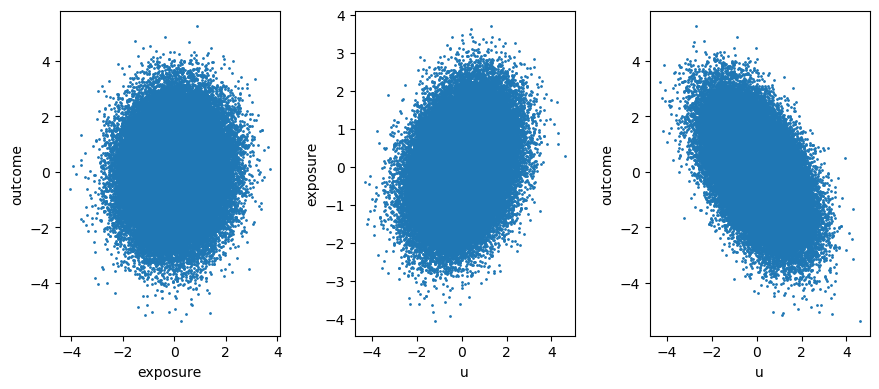

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4))

pairs = (
    ("exposure", "outcome"),
    ("u", "exposure"),
    ("u", "outcome")
)

for i, (x, y) in enumerate(pairs):
    axes[i].scatter(sim.get_variable_data(x), sim.get_variable_data(y), s=1)
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
    
plt.tight_layout()

In [8]:
# Simulations can be saved using the "dill" package.
# This allows easy sharing of simulation models.
# The original data will be saved.
sim.save_pickle("sim.pkl")
sim2 = mr_sim.Simulation.load_pickle("sim.pkl")
sim2._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,exposure,outcome
0,0.045562,1,0,0,1,1,1,0,0,0,0,0,1,0,0,2,0.104951,0.422990
1,0.218717,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,-1.223171,-0.971715
2,0.732219,0,1,0,0,0,0,0,1,1,0,1,1,1,0,0,-0.744843,-1.234999
3,0.329043,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,-1.907172,-1.131527
4,-0.185740,1,0,1,1,0,0,0,1,0,0,0,0,1,1,1,-0.585778,0.262339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.283062,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0.555856,-0.226202
99996,-0.659217,1,2,0,0,0,1,0,1,0,0,0,0,0,0,0,0.241710,0.648540
99997,-0.467968,1,0,1,1,1,1,0,1,1,0,0,0,1,0,1,0.407486,-1.269592
99998,-0.185422,0,1,0,0,0,1,0,2,0,1,0,0,0,0,1,0.779653,0.907341


In [9]:
# And resampling should also work as expected!
sim2.resample()
sim2._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,exposure,outcome
0,0.092140,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1.818012,-0.541439
1,-1.681643,0,1,0,2,0,0,0,1,0,1,0,0,1,0,1,-0.887522,-0.765025
2,-1.168367,0,0,0,1,0,0,1,2,0,0,0,1,0,0,1,-0.722342,0.334074
3,0.672438,1,2,0,0,0,1,1,0,0,1,0,0,2,0,0,-1.314761,0.816136
4,-0.341352,1,0,0,1,0,2,0,1,0,0,0,0,1,0,0,0.848909,0.517363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-1.652165,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.835241,0.038872
99996,-0.747581,0,1,0,1,0,1,0,0,0,0,2,0,2,0,0,0.133888,1.250647
99997,0.929994,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0.157492,0.321871
99998,1.635187,1,1,1,0,0,2,0,2,2,0,1,0,1,0,0,0.373988,-0.027259
